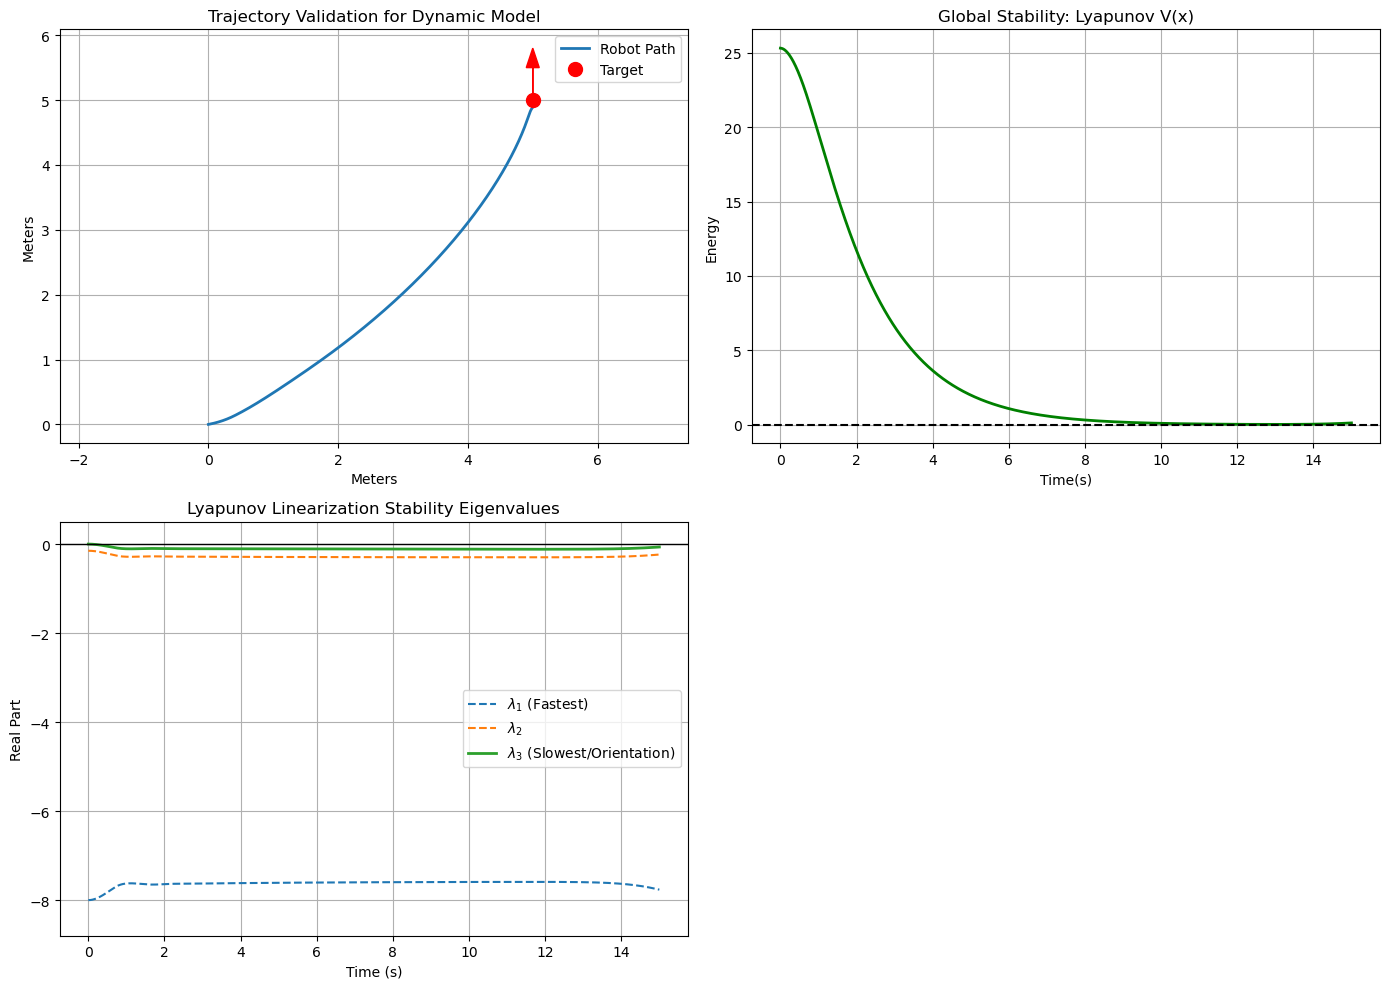

Final Error Distance: 0.0980 m
Final Eigenvalues: [-7.7649095  -0.23478736 -0.06551578]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure
import matplotlib.backends.backend_agg
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
import IPython

from robot_models import DynamicRobot
from controllers import LyapunovController

dt = 0.01
total_time = 15.0
steps = int(total_time / dt)

robot = DynamicRobot(wheelbase=0.33, max_steer=np.radians(45), max_force=20.0) 

controller = LyapunovController(k_rho=0.3, k_alpha=8.0, k_beta=-3.0) 

target_state = [5.0, 5.0, np.pi/2]

history = {
    'x': [], 'y': [], 'theta': [], 
    'v': [], 'steering': [], 'energy': [],
    'eig_real': [] #
}

# Simulation Loop
for i in range(steps):
    current_state = robot.state[0:3] 
    current_velocity = np.hypot(robot.state[3], robot.state[4]) 
    
    v_cmd, steer_cmd, energy = controller.compute_commands(
        current_state, target_state, wheelbase=robot.L
    )
    dx = target_state[0] - current_state[0]
    dy = target_state[1] - current_state[1]
    rho = np.hypot(dx, dy)
    alpha = np.arctan2(dy, dx) - current_state[2]
    alpha = (alpha + np.pi) % (2 * np.pi) - np.pi
    beta = target_state[2] - current_state[2] - alpha
    beta = (beta + np.pi) % (2 * np.pi) - np.pi
    
    if abs(alpha) > np.pi / 2:
        alpha = (alpha + np.pi) % (2 * np.pi) - np.pi
        beta = (beta + np.pi) % (2 * np.pi) - np.pi
    
    k_r, k_a, k_b = controller.k_rho, controller.k_alpha, controller.k_beta
    c_a = np.cos(alpha)
    s_2a = np.sin(2 * alpha)
    c_2a = np.cos(2 * alpha)
    
    # Jacobian
    j11 = -k_r * (c_a**2)
    j12 =  k_r * rho * s_2a if rho > 1e-3 else 0 
    j13 = 0
    j21 = 0
    j22 = -k_a + k_r * c_2a
    j23 = -k_b
    j31 = 0
    j32 = -k_r * c_2a
    j33 = 0
    
    J = np.array([[j11, j12, j13],
                  [j21, j22, j23],
                  [j31, j32, j33]])
                  
    eigvals = np.linalg.eigvals(J)
    history['eig_real'].append(sorted([e.real for e in eigvals]))
    Kv = 10.0 
    force_cmd = Kv * (v_cmd - current_velocity)
    
    robot.update(throttle_force=force_cmd, steering_angle=steer_cmd, dt=dt)
    
    history['x'].append(robot.state[0])
    history['y'].append(robot.state[1])
    history['theta'].append(robot.state[2])
    history['v'].append(robot.state[3])
    history['steering'].append(steer_cmd)
    history['energy'].append(energy)

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# Plot 1: Trajectory (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(history['x'], history['y'], label='Robot Path', linewidth=2)
ax1.plot(target_state[0], target_state[1], 'ro', label='Target', markersize=10)
ax1.arrow(target_state[0], target_state[1], 
          0.5*np.cos(target_state[2]), 0.5*np.sin(target_state[2]), 
          head_width=0.2, color='red')
ax1.set_title("Trajectory Validation for Dynamic Model")
ax1.set_xlabel("Meters")
ax1.set_ylabel("Meters")
ax1.grid(True)
ax1.axis('equal')
ax1.legend()

# Plot 2: Lyapunov Energy (Top Right)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(np.linspace(0, total_time, steps), history['energy'], color='green', linewidth=2)
ax2.set_title("Global Stability: Lyapunov V(x)")
ax2.set_xlabel("Time(s)")
ax2.set_ylabel("Energy")
ax2.grid(True)
ax2.axhline(0, color='black', linestyle='--')

# Plot 3: Linearization
ax3 = fig.add_subplot(gs[1, 0]) 
time_axis = np.linspace(0, total_time, steps)
eig_data = np.array(history['eig_real'])

ax3.plot(time_axis, eig_data[:, 0], label='$\lambda_1$ (Fastest)', linestyle='--')
ax3.plot(time_axis, eig_data[:, 1], label='$\lambda_2$', linestyle='--')
ax3.plot(time_axis, eig_data[:, 2], label='$\lambda_3$ (Slowest/Orientation)', linewidth=2)

ax3.set_title(f"Lyapunov Linearization Stability Eigenvalues")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Real Part")
ax3.legend()
ax3.grid(True)

ax3.axhline(0, color='black', linewidth=1)
ax3.set_ylim(min(np.min(eig_data), -1.0) * 1.1, 0.5)

plt.tight_layout()
plt.show()

print(f"Final Error Distance: {np.hypot(history['x'][-1]-target_state[0], history['y'][-1]-target_state[1]):.4f} m")
print(f"Final Eigenvalues: {eig_data[-1]}")

In [3]:
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

# Downsample data for smoother/faster rendering
skip = 5
sim_x = history['x'][::skip]
sim_y = history['y'][::skip]
sim_theta = history['theta'][::skip]
sim_steer = history['steering'][::skip]

fig = matplotlib.figure.Figure(figsize=[8, 8])
matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1, 7], ylim=[-1, 7])
ax.set_aspect('equal')
ax.grid(True)
ax.set_title(f"Lyapunov Controller Validation (Tuned)")

# Draw Target (Static)
ax.plot(target_state[0], target_state[1], 'ro', markersize=10, label='Target')
ax.arrow(target_state[0], target_state[1], 
         0.5*np.cos(target_state[2]), 0.5*np.sin(target_state[2]), 
         head_width=0.2, color='red')

# --- ARTISTS SETUP ---
# Robot Body
L, W = 0.33, 0.2 
robot_body = Rectangle((0, 0), L, W, color='blue', alpha=0.3)
ax.add_patch(robot_body)

# Wheels (represented as small thick lines)
fl_wheel, = ax.plot([], [], 'k-', linewidth=3)
fr_wheel, = ax.plot([], [], 'k-', linewidth=3)
rl_wheel, = ax.plot([], [], 'k-', linewidth=3)
rr_wheel, = ax.plot([], [], 'k-', linewidth=3)

# Trace line
trace, = ax.plot([], [], 'b-', linewidth=1, alpha=0.5)

# Wheel dimensions for drawing
wheel_len = 0.1

def get_corner_pos(x, y, theta, x_local, y_local):
    """Rotate local point to global frame"""
    gx = x + x_local * np.cos(theta) - y_local * np.sin(theta)
    gy = y + x_local * np.sin(theta) + y_local * np.cos(theta)
    return gx, gy

def get_wheel_line(x, y, theta, x_rel, y_rel, angle_rel):
    """Helper to calculate wheel endpoints in global frame"""
    # Wheel center in global
    cx, cy = get_corner_pos(x, y, theta, x_rel, y_rel)
    # Wheel endpoints (global angle = theta + angle_rel)
    wa = theta + angle_rel
    w_x = [cx - (wheel_len/2)*np.cos(wa), cx + (wheel_len/2)*np.cos(wa)]
    w_y = [cy - (wheel_len/2)*np.sin(wa), cy + (wheel_len/2)*np.sin(wa)]
    return w_x, w_y

def init():
    """Initialize artists to empty"""
    robot_body.set_xy((0, 0))
    fl_wheel.set_data([], [])
    fr_wheel.set_data([], [])
    rl_wheel.set_data([], [])
    rr_wheel.set_data([], [])
    trace.set_data([], [])
    return [robot_body, fl_wheel, fr_wheel, rl_wheel, rr_wheel, trace]

def update(frame):
    x = sim_x[frame]
    y = sim_y[frame]
    theta = sim_theta[frame]
    steer = sim_steer[frame] 
    
    # 1. Update Trace
    trace.set_data(sim_x[:frame], sim_y[:frame])
    
    # 2. Update Body 
    corner_x, corner_y = get_corner_pos(x, y, theta, 0, -W/2) 
    robot_body.set_xy((corner_x, corner_y))
    robot_body.angle = np.degrees(theta)
    
    # 3. Update Wheels
    if abs(steer) > 0.001:
        R = L / np.tan(steer)
        if steer > 0:
            fl_angle = np.arctan(L / (R - W/2))
            fr_angle = np.arctan(L / (R + W/2))
        else:
            fl_angle = -np.arctan(L / (abs(R) + W/2))
            fr_angle = -np.arctan(L / (abs(R) - W/2))
    else:
        fl_angle, fr_angle = 0.0, 0.0
        
    # Front Left
    w_x, w_y = get_wheel_line(x, y, theta, L, W/2, fl_angle)
    fl_wheel.set_data(w_x, w_y)
    
    # Front Right
    w_x, w_y = get_wheel_line(x, y, theta, L, -W/2, fr_angle)
    fr_wheel.set_data(w_x, w_y)
    
    # Rear Left (Fixed)
    w_x, w_y = get_wheel_line(x, y, theta, 0, W/2, 0)
    rl_wheel.set_data(w_x, w_y)
    
    # Rear Right (Fixed)
    w_x, w_y = get_wheel_line(x, y, theta, 0, -W/2, 0)
    rr_wheel.set_data(w_x, w_y)

    return [robot_body, fl_wheel, fr_wheel, rl_wheel, rr_wheel, trace]

# Create Animation
ani = FuncAnimation(fig, update, frames=len(sim_x), 
                    init_func=init, interval=50, blit=True)

# Close the static plot to prevent double display
plt.close(fig)

# Display as HTML5 Video
IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAExNRtZGF0AAAAAgkQAAAA
GGdCwB+VoDIGWhAAAAMAEAAAAwKA2giEagAAAARozjyAAAAAMwYFLwL4YVD8cEFytzJI86cqPTRN
aWNyb3NvZnQgSC4yNjQgRW5jb2RlciBWMS41LjMAgAAAAO0GBenLshOSmHND2qimx0KYNWz1c3Jj
OjMgaDo4MDAgdzo4MDAgZnBzOjIwLjAwMCBwZjo2NiBsdmw6OSBiOjAgYnFwOjMgZ29wOjIwIGlk
cjoyMCBzbGM6MSBjbXA6MCByYzoxIHFwOjI2IHJhdGU6MjAwMDAwIHBlYWs6MCBidWZmOjc1MDAw
IHJlZjoxIHNyY2g6MzIgYXNyY2g6MSBzdWJwOjEgcGFyOjYgMyAzIHJuZDowIGNhYmFjOjAgbHA6
MiBjdG50OjAgYXVkOjEgbGF0OjAgd3JrOjE2IHZ1aToxIGx5cjoxIDw8AIAAAB3AZYiAS///8PRQ
ABAg99999999999999999999999999999999999999999999999999dddddddddddddddddddddd
dddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd
ddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddcdgAIIpSEO
YxSkOcxj//4HIAwANcDpjuDsAFozBIiqcyHvv/ACB9DVsLaraRQeAA/kOMx+kEaQve2Am8hQcdY/
+vFYV4fTIxdX4AyRsJUyS0hi33SbCWY7HIiMnvg//zx//zGFeAOZDJG4uIxbrX5kRjVCERxfQj/C
z1CWq0W/ALEZB6GUtckf7/68QhXw6MTkV68AKLcRTH0T9uhf7HNz3wCZM2iFldWRf/qHwr/UyNTF
1T7+1kNjcdpCmm7X4AKH8Zjj2py3P/iOAQrwFNWeIGdNjtI9Isd5AMgWLRUP//vwUlQutyr7vArY
C33BwiTN9/9eIQr2k94H/88BcyGQkOhKOVD/vj4kEq1GONq3LoyKIDF1ghV/9Txwr+MsEozr8lJK
nkuIyhsarB2uUu6GK2Fby6++JBMPaokX/14JCvAHZCX5jjau+HgAQFBhNMxwAC4OwAKoGD7oa7Hv
/gvGFeHgkMO8xT34DaI3CKJq77BTGwmWStzF3wJ5mJccgqEX4dgCAADIEEtMNtNgb1t//gAEhyuB
FobFgg9gUmtetMBqWUCtcREBn8/+C9IV4F/DMywKadxu/A2hL4hRNXfY8AAgAoY2mAFNoPlHbe7f
f/TuEK8Eo9geUyXIlfeCwTCSSSYx48wVEkah0NC1tCAKL5KZtJj8ABAEoUjFsVpOLaxTf/agNgpg
2pgMbm1sgj/2rAOslANMOp/AvIwoPhU0/dr/8NcK8Hg7A/ybI1s8DwSGHaUpr8wVkJ/mONrb4BNM
xoZoo6WKT/8Vwwr4BMVKwvIHgFH69d/z8AHnYZjjypzTP/mPeFeBsCG63Q/YEpvtsDb5Gxj8aNgM
CoJuORFBd3mwnmYf0RTeLf/+eKwr+K2NjJOOtilvNEZmgmRRd5G/xk3kTZoyVcGyZNj7/8cMK8Ao
toimNWT26JtEMnLffgAZSYERZhTRWFX/3DQIV+5DIIA5VJDcc4Bcda2sOxoxn79jB2ozp9666666
6666666666666///EIV8ABkiIgZCZhjR+mewI/VBW+EcSff9v//4YV6QK+W6r7777777/w0xh4f3
cAGBWkDBRRSPuoyq0NsQ4nchyy54Rf//IFG+ACC1am37WOd42Cb2r77TyA31cKQjkif39sXaxpBR
vPvarwCBz7qknTu/zpEicao9pDQvCE+sXNbXIBOqAhS7nSsKLv3NEKRqkFxMdeHEMkRgwd+/BXaA
5kYSMnnav/+GmdYaOqoSGIRyv+DxXsGCre+iAU27vkcLxCLn738A7CdRJrj5KDp9YaW1hEM7kv/n
gAZYnFuKIYS9iHa+B+JgAYgDB/B/hRpbjgHCUb5doBcEPKIQYTCFr21kzxSmIBWYSjv8elMxEbVl
Ap77HsXg9mZtR0Vg8eEvTAp4UcKxu2dfs1HWHLHKJ9f++wbAkvdyie5PTUmVshxQ26VK0JGueAV4
d+pr8JuHq5lRSe9t0Xiqopz/5tboPgGEtmwaSOzoHn/3mGgGs5eEmGT965VhOQ7Mc/568AGSI8H8
//cvJQFIQ45V4KXHZbtywoLEh/8JXKMNsKmPB4F1riJlsdbO/Ap5AThZpVwfv94KCtXrkUI1zMiw
YdK30UCm3WNgV9XCfz9zE4BfkKQ4xxz9qgNBOGAcJe+RwqmBPnbT+4mjWLuIzWzPaZPMSYGKQtuA
N8cY0rVDA7CA7//1FSjAPUjSBjBdZtCi9DJhkVADDwltSG7imncLKH59OxFJwkc+6hoWDPQw1Yzj
Kt/XHma8D7nP4Nr9BxbYkpAytaNaNfYMCMMs5nIcLWN/qg34YBwlxUNOJPrOFVf/edcyRnHuSIVo
X5eRSMb9Xxhe8iGeO4zQlj3hiWS8NjIuIgX4Bwlw4gEYGZVi/Nk23tKDCUhJSckW3i//4hLyuEbA
XLdn/uu9BOe2MRahMP15Sz2BhZTa8UYS1BjwSCMjYAHhKCh5NGtce/siHKlHydr8/UnNEIIRJf/e
wPM16hNnIME9UOjM3bjIiQB4YBwlwQII9t861mK8uBVUDohWxNpEOuFiL+Yohi8Q+XhJVFvdqcKw
i0h9EHyocIcA4S2uWBOsgk7IylAChn9hZkznDq8ZOLLhDW/aKIE/RXGXA6XaA4YlevIPvfwSKLN/
U8ZRDRO5fpY6UgmNn//XRgR6ww8JeVsEALFTdQ953aDPaUsG6oksnusHGi1BvDu09kEVJ1Z+bqqP
QZQAiLYGtYfb/15+FB1ASyy4gida4aR6kN2KtoFRQaHhwlDA9iSmDK1sj2mfvAjDLOZyHC1jU9qo
acSfXJwq/465kjOPcohXhfl5VIxv1fFC95EMkn4BzDFeJFEwz8Ka+oDPtfHg4EZV/sbB56eDi2Ay
WYYleYGTktxlaFKQ0m2v2D6Mu48TD6MELsTlJWFSO8GIHgAURhHtE8inoen/9oPrIj6nYoKaf/5J
gGAcJRGZLtOIW5+Wdg0FLF/B8SIgU6uBTXw0I/3NgltPsBM38RgQxleVKGSf8JeoDP8BrkV1O9PL
8R4pjCMQbXGFHZeJJxPcJwUUACAfEG6wEFjk5MB010C/akFp8YpQFWD8v/uNARF9XAsWrhVqw4vG
23vcjX/0P4YFhfrK+rgQR2v/WxiQaJmoPF65sJyiy7/ZtSs9LPBnAa4EERjl/659oFYYHNmNmin+
BmhWOeiIXy/e/f17e23P++++++++++uuuuuuuuuv6NbH+Evo/kSY6id2EG3KhRqaQ91oFITfTHLl
5/X8+YAH/8JQAUhHMmCFi+J33iYjP0UoHO/lEC/GWDtFLfe7778YcP/D0AGXpG6CcD0ZwNLdy9X3
3+H/+HoAQKZqg3HcB/eK33/8P+H8ADf6Ymkne7v+H/+HvQfvvv/wH/h+ACS9jazZ2z9fe777/hw/
4SwAZekbkE4+PTBgaWp94u++/4f/wlgBApmqDcd/gPvFb778YB//D0ADf6Ymkne7oPf7778fw/4f
wAORDYWQl5Py1E7fX666666666663XXXXWq6666xWuuuuuuuuuuuuusrK6666xWuuuuuuuuuuuuu
uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu
uuuuuuuuuuuuuuuuuuuuu

Planning path through obstacle course...
Searching... 2000 nodes. Dist: 9.85m
Goal Found after 2118 steps!
Best path generated.


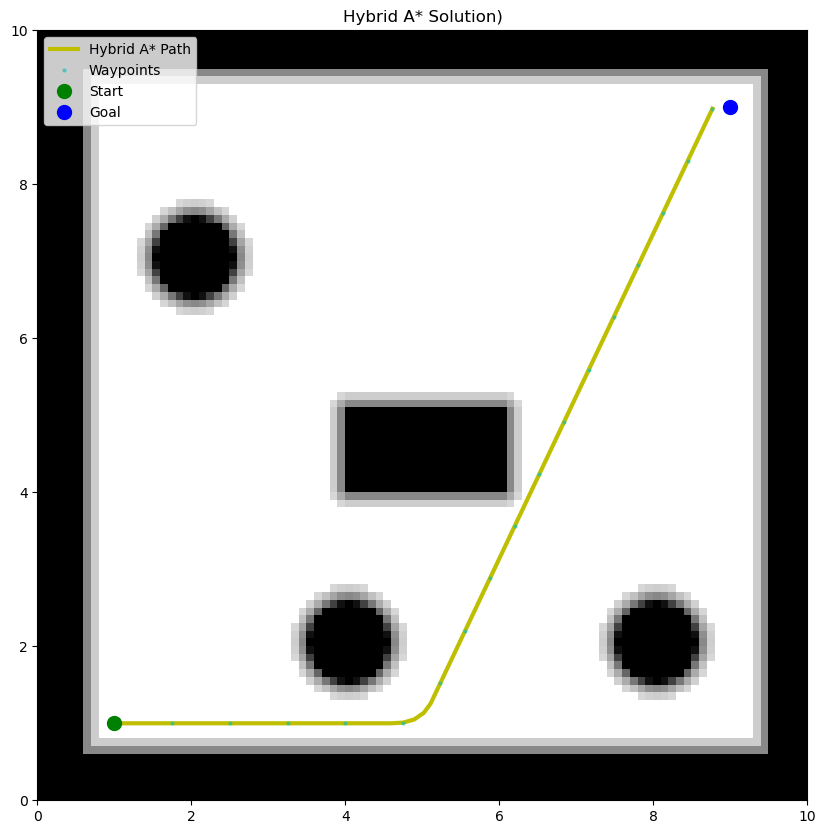

In [5]:
import matplotlib.pyplot as plt
from maps import OccupancyGridMap
from planner import HybridAStar

world_map = OccupancyGridMap(x_width=10, y_width=10, resolution=0.1, safety_margin=0.25)

# Outer Walls
world_map.add_rect_obstacle(0, 0, 10, 0.5)
world_map.add_rect_obstacle(0, 9.5, 10, 0.5)
world_map.add_rect_obstacle(0, 0, 0.5, 10)
world_map.add_rect_obstacle(9.5, 0, 0.5, 10)

# Obstacles 
world_map.add_rect_obstacle(4, 4, 2, 1)      # Central Block
world_map.add_circle_obstacle(2, 7, 0.5)     # Pillar Top-Left
world_map.add_circle_obstacle(8, 2, 0.5)     # Pillar Bottom-Right
world_map.add_circle_obstacle(4, 2, 0.5)     # Pillar Bottom-Center

# 2. Setup Planner
planner = HybridAStar(resolution=0.1, max_steer=0.78)
planner.SAFETY_GAIN = 15.0

# 3. Define Start and Goal
start = [1.0, 1.0, 0.0]  # Bottom Left
goal  = [9.0, 9.0, 0.0]  # Top Right

print("Planning path through obstacle course...")
result = planner.search(start, goal, world_map)

# 4. Visualize
fig, ax = plt.subplots(figsize=(10, 10))
world_map.plot(ax)

if result is not None:
    path_x, path_y, path_yaw = result
    ax.plot(path_x, path_y, 'y-', linewidth=3, label="Hybrid A* Path")
    
    # Plot 'footprint' of robot along path
    ax.plot(path_x[::5], path_y[::5], 'c.', markersize=4, alpha=0.5, label="Waypoints")
    
    print("Best path generated.")
    ax.set_title(f"Hybrid A* Solution)")
else:
    print("❌ No path found!")
    ax.set_title("Planning Failed: Stuck in Obstacles")

ax.plot(start[0], start[1], 'go', markersize=10, label="Start")
ax.plot(goal[0], goal[1], 'bo', markersize=10, label="Goal")
ax.legend()

plt.show()

In [7]:
import copy

ROBOT_L = 0.33
ROBOT_W = 0.20
MAX_STEER = 0.78
MAX_FORCE = 20.0
DT = 0.05
MAX_TIME = 30.0

START = [1.0, 1.0, 0.0]  # Start at (1, 1)
GOAL  = [9.0, 9.0, 0.0]  # Goal at (9, 9)

MAP_WIDTH = 10.0
MAP_HEIGHT = 10.0
PLANNING_SAFETY_MARGIN = 0.2

# 1. SETUP MAPS
vis_map = OccupancyGridMap(x_width=MAP_WIDTH, y_width=MAP_HEIGHT, resolution=0.1, safety_margin=0.0)

cost_map = OccupancyGridMap(x_width=MAP_WIDTH, y_width=MAP_HEIGHT, resolution=0.1, safety_margin=PLANNING_SAFETY_MARGIN)

def add_obstacles(target_map, use_safety_margin):
    # Temporarily set the map's safety margin for the current population run
    original_safety_margin = target_map.safety_margin
    target_map.safety_margin = use_safety_margin 

    # Boundary Obstacles
    target_map.add_rect_obstacle(0, 0, 10, 0.5)        # Bottom
    target_map.add_rect_obstacle(0, 9.5, 10, 0.5)      # Top
    target_map.add_rect_obstacle(0, 0, 0.5, 10)        # Left
    target_map.add_rect_obstacle(9.5, 0, 0.5, 10)      # Right
    
    # Internal Obstacles
    target_map.add_rect_obstacle(4, 4, 2, 1)          # Central Block
    target_map.add_circle_obstacle(2, 7, 0.5)          # Pillar 1
    target_map.add_circle_obstacle(8, 2, 0.5)          # Pillar 2
    target_map.add_circle_obstacle(4, 2, 0.5)          # Pillar 3

    target_map.safety_margin = original_safety_margin 

# Populate maps correctly:
# 1. vis_map gets NO gradient (0.0 margin) for clean plotting.
add_obstacles(vis_map, 0.0) 
# 2. cost_map gets the REQUIRED gradient (0.2 margin) for path planning.
add_obstacles(cost_map, PLANNING_SAFETY_MARGIN) 

# 2. Plan
print("Planning Path...")
planner = HybridAStar(resolution=0.1, max_steer=MAX_STEER)
# *** Planner now uses the cost_map (with gradient) ***
path_result = planner.search(START, GOAL, cost_map) 

if path_result is None:
    print("Planner failed. Path may be blocked by inflated obstacles.")
    path_points = [tuple(START)]
else:
    path_points = list(zip(*path_result))
    print(f"Path found with {len(path_points)} waypoints.")

print("Simulating...")
robot = DynamicRobot(wheelbase=ROBOT_L, max_steer=MAX_STEER, max_force=MAX_FORCE)

# Tuned Controller Gains
controller = LyapunovController(k_rho=1.5, k_alpha=1.0, k_beta=-0.5)

robot.state = np.array([START[0], START[1], START[2], 0, 0, 0])

steps = int(MAX_TIME / DT)
waypoint_idx = 0
history = {'x': [], 'y': [], 'theta': [], 'steer': []}

for i in range(steps):
    rx, ry, rtheta = robot.state[0:3]
    
    if waypoint_idx < len(path_points) - 1:
        try:
            tx, ty, _ = path_points[waypoint_idx]
        except ValueError:
            tx, ty = path_points[waypoint_idx][0], path_points[waypoint_idx][1]

        # Advance waypoint when robot is close
        if np.hypot(tx - rx, ty - ry) < 0.4:
            waypoint_idx += 1
            
    target_pt = path_points[waypoint_idx]
    
    # Calculate control commands
    v_cmd, steer_cmd, _ = controller.compute_commands([rx, ry, rtheta], target_pt, ROBOT_L)
    
    # Calculate force command based on velocity error
    current_vel = np.hypot(robot.state[3], robot.state[4])
    force_cmd = 10.0 * (v_cmd - current_vel)
    
    # Update robot state (dynamics)
    robot.update(force_cmd, steer_cmd, DT)
    
    # Log state
    history['x'].append(rx); history['y'].append(ry)
    history['theta'].append(rtheta); history['steer'].append(steer_cmd)

    # Check for goal achievement
    if waypoint_idx == len(path_points) - 1 and np.hypot(target_pt[0]-rx, target_pt[1]-ry) < 0.2:
        print("Goal Reached")
        break

skip = 5
sim_data = {k: v[::skip] for k, v in history.items()}

fig = matplotlib.figure.Figure(figsize=[8, 8])
matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1, MAP_WIDTH+1], ylim=[-1, MAP_HEIGHT+1], aspect='equal')
ax.grid(True)
ax.set_title("Path Planning with Cost Map Gradient")

vis_map.plot(ax) 

if path_result: 
    # Green line path (calculated to avoid the cost gradient)
    ax.plot(path_result[0], path_result[1], 'g--', label="Plan", alpha=0.5)
    # Start and Goal Markers
    ax.plot(START[0], START[1], 'go', markersize=10)
    ax.plot(GOAL[0], GOAL[1], 'rx', markersize=10)


robot_body = Rectangle((0, 0), ROBOT_L, ROBOT_W, color='blue', alpha=0.5)
ax.add_patch(robot_body)
wheels = [ax.plot([], [], 'k-', lw=2)[0] for _ in range(4)]
trace, = ax.plot([], [], 'r-', lw=2)

def get_pos(x, y, theta, x_loc, y_loc):
    c, s = np.cos(theta), np.sin(theta)
    return x + x_loc*c - y_loc*s, y + x_loc*s + y_loc*c 

def update(frame):
    x, y, th, st = sim_data['x'][frame], sim_data['y'][frame], sim_data['theta'][frame], sim_data['steer'][frame]
    trace.set_data(sim_data['x'][:frame], sim_data['y'][:frame])
    robot_body.set_xy(get_pos(x, y, th, 0, -ROBOT_W/2))
    robot_body.angle = np.degrees(th)
    
    R = ROBOT_L / np.tan(st) if abs(st) > 0.001 else float('inf')
    angles = [0, 0, 0, 0] 
    if abs(st) > 0.001:
        angles[2] = np.arctan(ROBOT_L / (R - ROBOT_W/2)) 
        angles[3] = np.arctan(ROBOT_L / (R + ROBOT_W/2)) 
    
    offsets = [(0, ROBOT_W/2), (0, -ROBOT_W/2), (ROBOT_L, ROBOT_W/2), (ROBOT_L, -ROBOT_W/2)]
    for wheel, angle, (ox, oy) in zip(wheels, angles, offsets):
        cx, cy = get_pos(x, y, th, ox, oy)
        wa = th + angle
        wheel.set_data([cx - 0.05*np.cos(wa), cx + 0.05*np.cos(wa)],
                       [cy - 0.05*np.sin(wa), cy + 0.05*np.sin(wa)])
    return [robot_body, trace] + wheels

# This line displays the animation inline in Jupyter
ani = FuncAnimation(fig, update, frames=len(sim_data['x']), interval=50, blit=True)
plt.close(fig)
IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

Planning Path...
Searching... 2000 nodes. Dist: 9.25m
Searching... 4000 nodes. Dist: 7.47m
Searching... 6000 nodes. Dist: 9.50m
Searching... 8000 nodes. Dist: 8.16m
Searching... 10000 nodes. Dist: 5.71m
Searching... 12000 nodes. Dist: 7.70m
Searching... 14000 nodes. Dist: 7.06m
Searching... 16000 nodes. Dist: 8.43m
Goal Found after 17176 steps!
Path found with 90 waypoints.
Simulating...
Goal Reached


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABYo5tZGF0AAAAAgkQAAAA
GGdCwB+VoDIGWhAAAAMAEAAAAwKA2giEagAAAARozjyAAAAAMwYFLwL4YVD8cEFytzJI86cqPTRN
aWNyb3NvZnQgSC4yNjQgRW5jb2RlciBWMS41LjMAgAAAAO0GBenLshOSmHND2qimx0KYNWz1c3Jj
OjMgaDo4MDAgdzo4MDAgZnBzOjIwLjAwMCBwZjo2NiBsdmw6OSBiOjAgYnFwOjMgZ29wOjIwIGlk
cjoyMCBzbGM6MSBjbXA6MCByYzoxIHFwOjI2IHJhdGU6MjAwMDAwIHBlYWs6MCBidWZmOjc1MDAw
IHJlZjoxIHNyY2g6MzIgYXNyY2g6MSBzdWJwOjEgcGFyOjYgMyAzIHJuZDowIGNhYmFjOjAgbHA6
MiBjdG50OjAgYXVkOjEgbGF0OjAgd3JrOjE2IHZ1aToxIGx5cjoxIDw8AIAAACXfZYiAS///8PRQ
ABAg99999999999999999999999999999999999999999999999999dddddddddddddddddddddd
dddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd
ddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddcdgAIBiMe9
7GMY972Mf//wAJYnZBhRmp5e/+J4nCv5bEVB8r/y2Y0Jv5sEk2on3//jY8DCLNqYzN37f/ddVhXg
uAMaOgIjt4fr/AfMiGRyFNArXYJRobOBWtweRgOxDsYplcvf/DgsK/wHCcZaZgBREhsRwriQl9Ng
dI/zuBHrk/99/9wwCFeNQADYDbpJHPwGItC05VIyu+Ab5navfVPtf/4YBCvACXhHhrSSBTpJ+3xI
NbhJhMvsBMjGuITOdyEf4ybyJsxOjf/XgEK+uDZMmx8CUMSaU0g2WC37tgMkbCVMktIY1x2RsJYh
2FRz/68ThXvk94H/88HTIJEktIY0fYEUjH6bPCHpPjy8OwAG9phbzcpMX/8AHMTHTjLctPsQAjIL
c8wbUwggLG1HW5S/f/DnhXgjbQAX8BZFNrwC2BkMrdg7bcCCf95UAtVUKXyP0PAAKgCGB6YOwAEw
C3C2RRFE2SRRP/gbAS4ChA2p8PgAPyQVwcXPktJNf/d+MK/FUvuBi8/z/AHHIdBoiUe5Pv7k2NqO
tyl3wDYiU/uExa8f/ANRhX9l6rfWqgpZQUVBWuwNQaowkLX6lLgKp4AqVzcAp99/8+IQrwGTTXrT
Y0k0zAFkzyGCoJih4bOBR6CQp6QxXP/vxCFeBchSkYDjtkTKd/4GrILU7mI99hEtxNN33//hhgg4
ADsR7BJjposRFOyoVOuEqV1fv/wwwrwAJGAN2XsYAIrLAXMVgB0fDf0YDw6piEVh1NNP/97aYVJB
aRLyoePwAbFnsb5/ff/RkLHdBPYlPgjCJLHFMxfsUhPqJSy+sA0XtKZka/+K4YV/HyRDW4hRPSeg
ANlABwe5YF4gkV8MONlIvv4BiLQknKrMr/4BgsK/KkRtCVFW/AMXqt9btLhsauOU8/9bA2iHYxTK
Ufv/0wwQcBORi5HfxaCAwX0jcEgnlkGmUv/pdddddddddddddddddddcd//j392m3/8fgg477fff
ffff/Dxw4f/If6EdUzuiGLNx5Mg7A6MEOHCXWkDzlyhGJR2uKCpbD4Di9tWp+WsJO3LOTHCsZBZn
dlBAC1U3lPaK7gZba7wJFRJpP9oONlsrBPDu4aiIV/qV6oxqRhDgHCWj9DAGVagS5800kPxGoNgk
DtYNbTaK2/7HGownJ2grXcc0C1QgU19ha3/coJvZQcRbeIei9QH/eEAh4f+QreYCp2MSUUobw2Zh
nYayMR6dGxGETA4cEYADhwlBPCZrAWVDjql9/8DKAfRVG9ne1D/1wyAAP8gAR9ML1V7wOSg5Lvjb
xNx4oix38d8v3/3rywDAOEvSd3aBzma1ua5NlILtmDI/9A3xsrSNpNpIiBTq4FNe8d/vaMAnQOUg
DDwl5sEtp9gJm/nYMEKDHmUwYdbSaKBTbl+hAig8O5d9eZw8Evp02b2tmJPhiO9I8hfeBMyB8iiS
TGLS9kTYkwXSgir++Fq+hIpcq4KrXkOfwcCPmCOPEZoqnm+h64BjphMwUVynt/9KMwNAIeEsCOY9
ECmRUwPr9tCtimPGGFl5hNxgJ/YwBgm6jKRgDBVSKj/fHsAAmhg9AguzpfVBENGHEvkCQDhwlBO/
4AAQCAPEyWMN4GATCrMPobFKTcIOwo5k4sHflC4ec1cxTPesX2rlccgzDxTLpwoAcAwlz4mZAZnU
GY/IFKdoGH1unvuDH/1dAJw462YATdlYGRsQqz/o1UlRv+EoYePt6vBkI/z/AmFKdRZRzkeT/QEc
DmpjBHW1J4Q4sNrcRAs6YdzpIWLyVQ+qX7igURQvwkRCislCYVIPgHCXhclmxAtMaGM7DcQNQecE
mpLP121shotFizyr7UeISeKQH1F5vgBjmPxfd45/68AJcPFjP8tpunheHIKebv7FoMM3FDapLJrs
DylDDwlLef31W1z3PA9leYACB3NaUz/WBBqqVmm9uQ7/j1DZMw2fMFBr0mn5/ocEYADhwl77/gg1
zJxDiMNE4kbjXs/OBD5oNWXgkK/LNRbDgAc8cwCFo5DFGPFltXu804iwHNxpFbwXKa2Szg/8T2w9
2QKI5X7OHWQbcSn/ZQqOzzgVPlrFg+MKN0kFlC/PioQb44P8aMiGJSHDF3U/3/jwflGKu5sG57CQ
suGH1QVhHgHCV8gAExZpCDqsaQBB161jiizdoBsAAkdUQo6LmcwqACoeDf0aoG48ejlMpqXesoeq
K7CW2L6GCVXQbUo+M/+BDvxagBh4Svo3I58/K2AgKfcRHnXeC+cxLrH2kGxeMX6xNWOcnCZCBTIp
4RPObp+siI9Aw5Toeb+/94bKqsTQxGU9qHTmKZyKMbf+4JtSGHhLlM4OOJ/uHWnL9myWH4ZHHiSj
P//xOF9s6YEPtgAERboVAlT806/9/PCQ7LRBCdLO6/7SRGHwDhLj6E+OYTiKbVEWrAHYoV9PoFQA
KwFrE/ncbhZVxgqIy0f9xzgWqGCmv0LW/7lBJ7KDiLbxDkDYIdDp4fAIe1kjPjmNVz6371CCEGFf
94Dj3VGVkKuNp4JM78NRJRmPPvvvvvvvvrrrrrrrrrrr4YYf8JYAMyEqchQCiNXy4Zgp2qW5v34/
Afjw/ABHHmJpJ3+cPPTfffffe/AP/4egAYNUzUg3AwY2vvFb777/h/l4SwAMfuRuQToyuYIygaW9
X3333/8P+H8ADOPTE0k7/Rtl4K++++/4f/wlgAgamaSDd9zpji97vvvvx+H/h+ACH+RugnfD0ZQN
LY0x///4e0H34/h/w/gAFEMgoS8nxSibXciYX666666666666666666676xWuuuuusrC66666666
66663XXXXXWZddddddddddddcdgAIyIzMiIjMyI//+ACLMBE8hwcZg/+fUIV/gArDMb4csRpO+wG
Ptfd/4Ndddddddddddddddddddddddddddddddddddddddddddddddf84fPhTCGJACBy7Q58mQU1
NNKBCSJANCRsDi0//9DgWnBcvc2FzTqwkCJFQL/sJK+0Q6Jxy/+9AbeIFU7bRSdMwEtp0QEvezf7
+Swb5yDeRMEz+D4vQ2Olw6nLQ3BQ0TYpYvfB+7dveB/v+/+OwBCB/ivt78AB2GYy4KWK4nwC8Q6x
D5OMSc3rL+CCGJLDkMSX/